# Study of the results of the NN for dynamical system

This notebook studies teh results of the NN trained to predict PI from the multiple circles dataset. 
   1. We compare the time of calculation of PIs between Gudhi and the NN, 
   2. we look at the p-values of the Kolmogorov-Smirnov test on each pixels,
   3. we compare the classification results between a classifier trained on real PIs and trained on predicted PIs.

---

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from IPython.display import SVG

import gudhi as gd
import gudhi.representations

from tqdm import tqdm
from time import time

from scipy.stats import ks_2samp

2021-07-22 17:13:06.423922: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


The following file has functions that creates the dataset the NN was trained on.

In [2]:
from multiple_circle import create_random_circle, create_1_circle, create_2_circle, create_3_circle

### Load the NN

2021-07-22 17:13:30.345541: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-22 17:13:30.494795: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2021-07-22 17:13:30.494898: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: thibault-OMEN-by-HP-Laptop
2021-07-22 17:13:30.494923: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: thibault-OMEN-by-HP-Laptop
2021-07-22 17:13:30.506097: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.57.2
2021-07-22 17:13:30.506263: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.42.1
2021-07-22 17:13:30.506291: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 470.42.1 does not

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 600, 2)]          0         
_________________________________________________________________
fully_connected2 (FullyConne (None, 600, 30)           60        
_________________________________________________________________
tf.nn.relu (TFOpLambda)      (None, 600, 30)           0         
_________________________________________________________________
dense (Dense)                (None, 600, 20)           620       
_________________________________________________________________
dense_1 (Dense)              (None, 600, 10)           210       
_________________________________________________________________
lambda (Lambda)              (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                550   

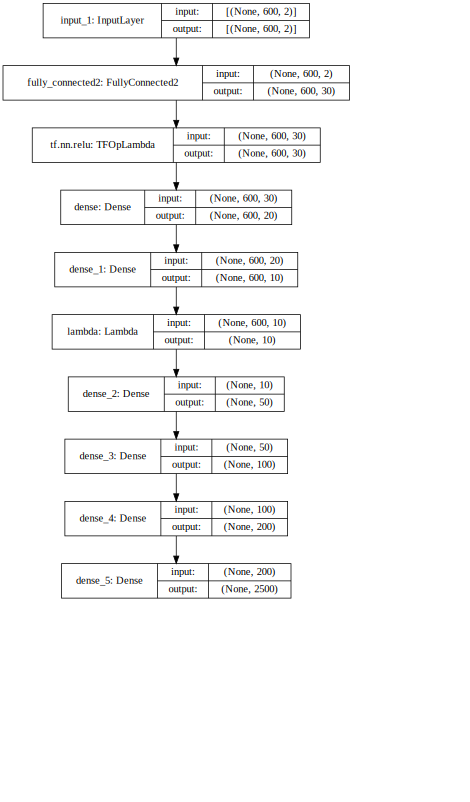

In [3]:
model_PI = tf.keras.models.load_model('../Trained_NN/model_multiple_cricles/')
model_PI.summary()

## Comparaison of calculation time


We start by generating new data

In [5]:
N_sets = 10
N_points = 600
PI_size = 50

In [59]:
data_sets = np.zeros((N_sets, N_points, 2))

for i in tqdm(range(N_sets), desc='Generating dataset : '):
    data_sets[i] = create_random_circle(N_points)

Generating dataset : 100%|█████████████████████| 10/10 [00:00<00:00, 189.77it/s]


We can plot the fists point clouds

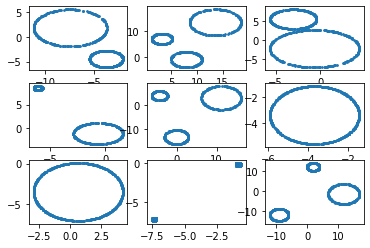

In [7]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.scatter(data_sets[i, :, 0], data_sets[i, :, 1], s=3)

### Compute their PI with the NN and save the time it took the NN

In [61]:
starttimeNN = time()
PI_NN = model_PI.predict(data_sets)
timeNN = time() - starttimeNN
print('Time taken by the NN = {} seconds'.format(timeNN))

Time taken by the NN = 0.16722893714904785 seconds


We can plot the predicted PIs.

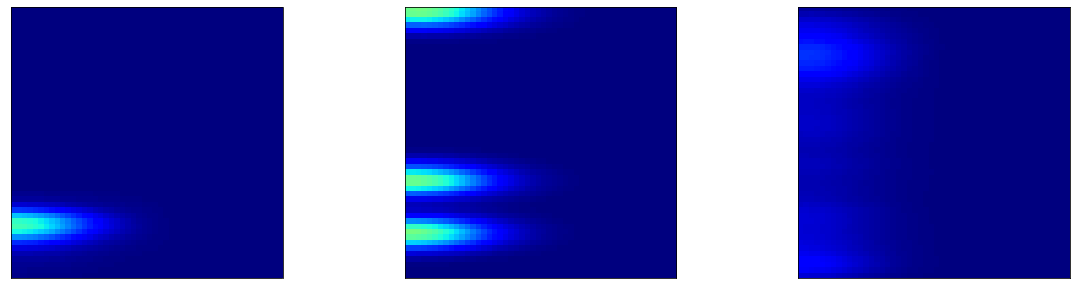

In [66]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i in range(3):
    #plt.subplot(1, 3, i + 1)
    axs[i].imshow(np.flip(np.reshape(PI_NN[i], [PI_size, PI_size]), 0),
               vmin=0,
               vmax=1,
               cmap='jet')
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
#plt.savefig("Rapports/Rapport_PRe/Images/multiple_circles_PI_predicted.pdf")   

### Compute their PI with Gudhi and save the time it took Gudhi

In [63]:
PI_gudhi = np.zeros((N_sets, PI_size * PI_size))

starttimeG = time()
for i in range(N_sets):
    rcX = gd.AlphaComplex(points=data_sets[i]).create_simplex_tree()
    dgmX = rcX.persistence()

    PI = gd.representations.PersistenceImage(
        bandwidth=1,
        weight=lambda x: 10 * np.tanh(x[1]),
        resolution=[PI_size, PI_size],
        im_range=[0, 5, 0, 25])
    pi = PI.fit_transform([rcX.persistence_intervals_in_dimension(1)])
    PI_gudhi[i] = pi[0]
timeG = time() - starttimeG
PI_gudhi /= np.max(PI_gudhi)
print('Time taken by Gudhi = {} seconds'.format(timeG))

Time taken by Gudhi = 0.457916259765625 seconds


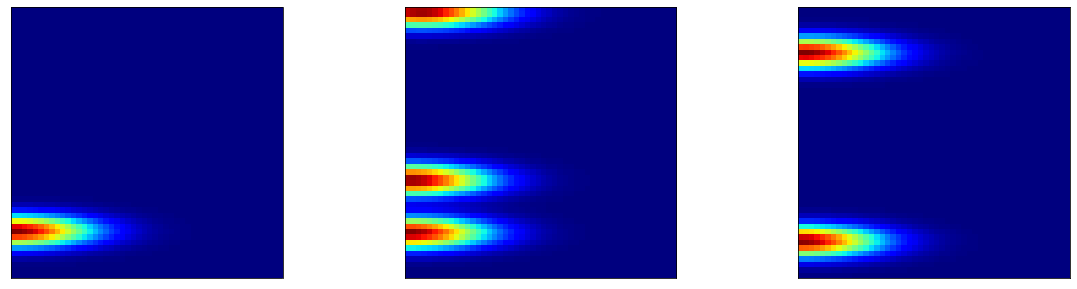

In [67]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i in range(3):
    #plt.subplot(1, 3, i + 1)
    axs[i].imshow(np.flip(np.reshape(PI_gudhi[i] /np.max(PI_gudhi), [PI_size, PI_size]), 0),
               vmin=0,
               vmax=1,
               cmap='jet')
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
plt.savefig("Rapports/Rapport_PRe/Images/multiple_circles_PI_true.pdf")


We compute the MSE between the true and predicted PIs.

In [27]:
(np.square(PI_NN - PI_gudhi)).mean(axis=None)

0.0014750175765151426

## Time Results

|Number of point clouds  | Time taken by the NN in sec | Time taken by Gudhi in sec| Mean Squared Error |
|:----------------:|:--------------------:|:-------------------:|:------------------:|
|        10        |        0.04463       |       0.53827       |       0.05269      |
|        100       |        0.04794       |       5.38901       |       0.04581      |
|       1000       |        0.13399       |       54.9103       |       0.04788       | 

## Kolmogorov-Smirnov test 

We test if the PI computed with the NN and the PI computed with Gudhi have the same distribution. 
$$(H_0) : D_{\text{NN}} = D_{\text{G}}$$
We use for that the Kolmogorov-Smirnov test. 

In [28]:
p_value_ks = np.zeros(PI_NN[0].shape)
for i in range(len(p_value_ks)):
    p_value_ks[i] = ks_2samp(PI_NN[:, i], PI_gudhi[:, i])[0]

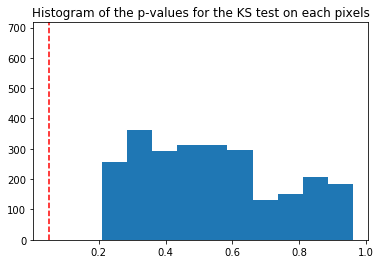

In [31]:
plt.hist(p_value_ks)
plt.vlines(0.05, 0, 800, linestyle='--', colors='red')
plt.ylim(0, 717)
plt.title("Histogram of the p-values for the KS test on each pixels")
#plt.savefig("Résultats/Résultats 4/hist_p_value_test_ks_circles.pdf")

No p-value is under 0.05, so all the KS tests are validated or at least we can not rejet $H_0$.

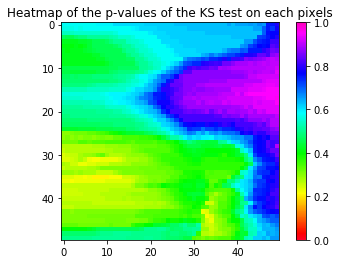

In [32]:
plt.imshow(np.flip(np.reshape(p_value_ks, [PI_size, PI_size]), 0),
           vmin=0,
           vmax=1,
           cmap='gist_rainbow')
plt.colorbar()
plt.title("Heatmap of the p-values of the KS test on each pixels")
#plt.savefig("Résultats/Résultats 4/heatmap_p_value_test_ks_circles.pdf")

-------

# Classification 

We want to compare the classification results between the true PIs and the predited PIs. For that, we create 2 models : ```model_classif_NN``` will be trained with the PI computed by the NN and ```model_classif_gudhi``` will be trained with the PI computed by Gudhi. We will then compare their accuracy on new data.

In [5]:
def create_model():
    inputs = tf.keras.Input(shape=(PI_size * PI_size))

    x = tf.keras.layers.Dense(100, activation='relu')(inputs)

    x = tf.keras.layers.Dense(50, activation='relu')(x)

    outputs = tf.keras.layers.Dense(3)(x)

    model_classif = tf.keras.Model(inputs=inputs, outputs=outputs)
    model_classif.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])
    return model_classif

In [6]:
model_classif_NN = create_model()
model_classif_gudhi = create_model()

model_classif_NN.summary()

#SVG(
#    tf.keras.utils.model_to_dot(model_classif,
#                                show_shapes=True).create(prog='dot',
#                                                         format='svg'))

#tf.keras.utils.plot_model(model_classif,
#                          to_file='Résultats/Résultats 2/model_classif_multip.pdf',
#                          show_shapes=True,
#                          rankdir='LR')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2500)]            0         
_________________________________________________________________
dense (Dense)                (None, 100)               250100    
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 153       
Total params: 255,303
Trainable params: 255,303
Non-trainable params: 0
_________________________________________________________________


### Load data for the training of ```model_classif_gudhi```

In [41]:
data = np.load('data/PI_data_multiple_circle_classif.npz')

#data = np.load('PI_data_1000_dynamical_alpha.npz')

label_train_gudhi = data["label_train"]
PI_train_gudhi = data["PI_train"]
label_test_gudhi = data["label_test"]
PI_test_gudhi = data["PI_test"]

In [42]:
N_sets_train = PI_train_gudhi.shape[0]
N_sets_test = PI_test_gudhi.shape[0]
PI_size = int(np.sqrt(PI_train_gudhi.shape[1]))

In [43]:
print("N_sets_train : ", N_sets_train)
print("N_sets_test : ", N_sets_test)
print("PI_size : ", PI_size)

N_sets_train :  999
N_sets_test :  99
PI_size :  50


In [44]:
PI_train_gudhi /= max(np.max(PI_train_gudhi), np.max(PI_test_gudhi))
PI_test_gudhi /= max(np.max(PI_train_gudhi), np.max(PI_test_gudhi))

In [45]:
label_train_gudhi -= 1
label_test_gudhi -= 1

### Fit the classification model ```model_classif_gudhi```

In [7]:
history_gudhi = model_classif_gudhi.fit(PI_train_gudhi,
                                        label_train_gudhi,
                                        epochs=100,
                                        validation_data=(PI_test_gudhi,
                                                         label_test_gudhi))

NameError: name 'PI_train_gudhi' is not defined

In [47]:
test_loss_gudhi, test_acc_gudhi = model_classif_gudhi.evaluate(
    PI_test_gudhi, label_test_gudhi, verbose=2)

print('\nTest accuracy:', test_acc_gudhi)

4/4 - 0s - loss: 0.0591 - accuracy: 0.9798

Test accuracy: 0.9797979593276978


 ### Generate data for the training of ```model_classif_NN```  

In [8]:
N_sets_train = 5000
data_train_NN = np.zeros((N_sets_train, N_points, 2))
label_train_NN = np.zeros((N_sets_train, ))

for i in tqdm(range(N_sets_train), desc='Generating dataset : '):
    r = np.random.randint(1, 4)
    label_train_NN[i] = r - 1
    if r == 1:
        data_train_NN[i] = create_1_circle(N_points)
    elif r == 2:
        data_train_NN[i] = create_2_circle(N_points)
    elif r == 3:
        data_train_NN[i] = create_3_circle(N_points)

Generating dataset : 100%|█████████████████| 5000/5000 [00:17<00:00, 289.11it/s]


In [9]:
PI_train_NN = model_PI.predict(data_train_NN)

2021-07-14 16:54:04.167987: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-14 16:54:04.242148: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2599990000 Hz


In [10]:
N_sets_test =1000
data_test_NN = np.zeros((N_sets_test, N_points, 2))
label_test_NN = np.zeros((N_sets_test, ))

for i in tqdm(range(N_sets_test), desc='Generating dataset : '):
    r = np.random.randint(1, 4)
    label_test_NN[i] = r - 1
    if r == 1:
        data_test_NN[i] = create_1_circle(N_points)
    elif r == 2:
        data_test_NN[i] = create_2_circle(N_points)
    elif r == 3:
        data_test_NN[i] = create_3_circle(N_points)

Generating dataset : 100%|█████████████████| 1000/1000 [00:03<00:00, 290.86it/s]


In [11]:
PI_test_NN = model_PI.predict(data_test_NN)

### Fit the classification model ```model_classif_NN```

In [12]:
history_NN = model_classif_NN.fit(PI_train_NN,
                                  label_train_NN,
                                  epochs=50,
                                  validation_data=(PI_test_NN, label_test_NN))

Epoch 1/50
157/157 [==============================] - 1s 3ms/step - loss: 0.3445 - accuracy: 0.8926 - val_loss: 0.2248 - val_accuracy: 0.9340
Epoch 2/50
157/157 [==============================] - 0s 2ms/step - loss: 0.2012 - accuracy: 0.9294 - val_loss: 0.2096 - val_accuracy: 0.9320
Epoch 3/50
157/157 [==============================] - 0s 2ms/step - loss: 0.1835 - accuracy: 0.9366 - val_loss: 0.2100 - val_accuracy: 0.9350
Epoch 4/50
157/157 [==============================] - 0s 2ms/step - loss: 0.1794 - accuracy: 0.9382 - val_loss: 0.1963 - val_accuracy: 0.9340
Epoch 5/50
157/157 [==============================] - 0s 2ms/step - loss: 0.1712 - accuracy: 0.9390 - val_loss: 0.1867 - val_accuracy: 0.9360
Epoch 6/50
157/157 [==============================] - 0s 2ms/step - loss: 0.1736 - accuracy: 0.9382 - val_loss: 0.1695 - val_accuracy: 0.9400
Epoch 7/50
157/157 [==============================] - 0s 2ms/step - loss: 0.1635 - accuracy: 0.9380 - val_loss: 0.1784 - val_accuracy: 0.9390
Epoch 

In [13]:
test_loss, test_acc = model_classif_NN.evaluate(PI_test_NN,
                                                label_test_NN,
                                                verbose=2)

print('\nTest accuracy:', test_acc)

32/32 - 0s - loss: 0.1617 - accuracy: 0.9400

Test accuracy: 0.9399999976158142


| Test accuracy for PI computed by Gudhi 	| Test accuracy for PI computed by NN 	|
|:--------------------------------------:	|:-----------------------------------:	|
|                   98%                  	|                 86%                 	|

### Study of the mislabled data

In [14]:
pred = model_classif_NN.predict(PI_test_NN)

In [15]:
pred = np.argmax(model_classif_NN.predict(PI_test_NN),1)

In [16]:
mislabeled = tf.not_equal(pred, label_test_NN)

In [17]:
mislabeled_PI = tf.boolean_mask(PI_test_NN, mislabeled)

Number of mislabled data :

In [18]:
len(mislabeled_PI)

60

We plot the mislabled data and save them.

/tmp/ipykernel_7312/3319998844.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/tmp/ipykernel_7312/3319998844.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/tmp/ipykernel_7312/3319998844.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/tmp/ipykernel_7312/3319998844.py:3: 

/tmp/ipykernel_7312/3319998844.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/tmp/ipykernel_7312/3319998844.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/tmp/ipykernel_7312/3319998844.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/tmp/ipykernel_7312/3319998844.py:3: 

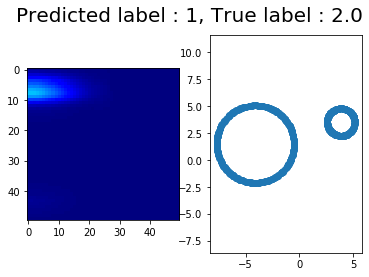

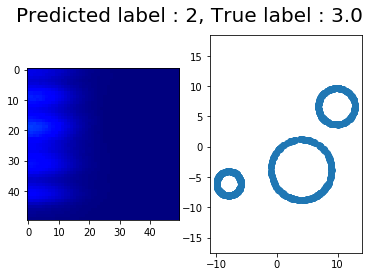

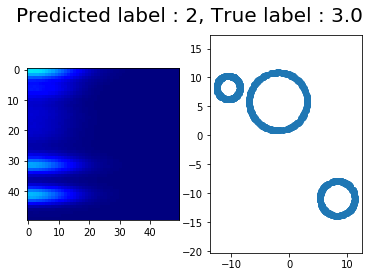

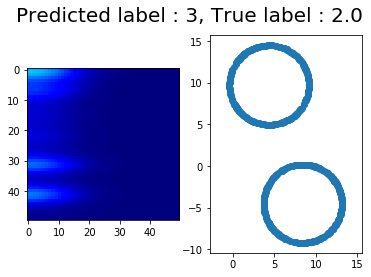

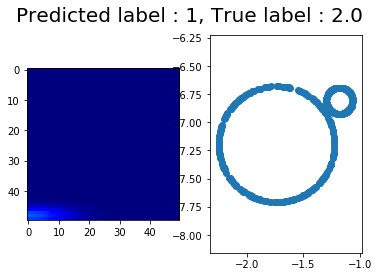

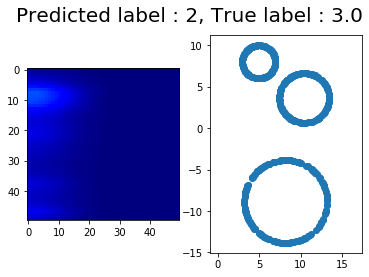

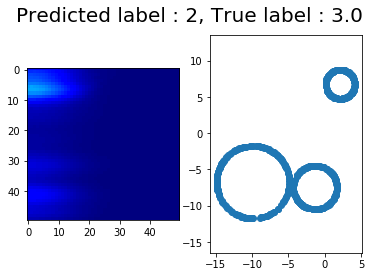

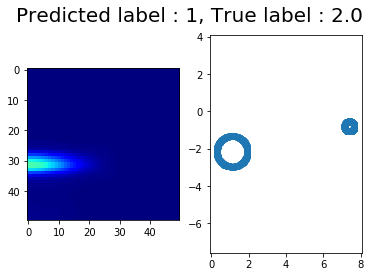

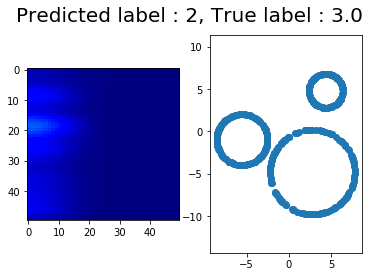

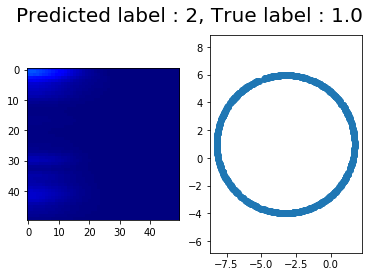

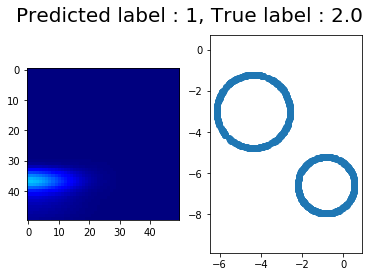

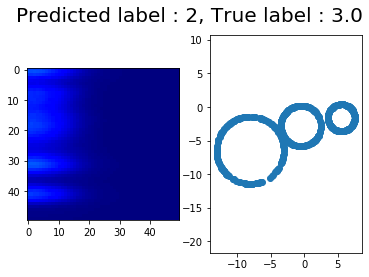

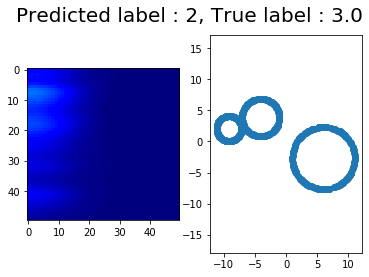

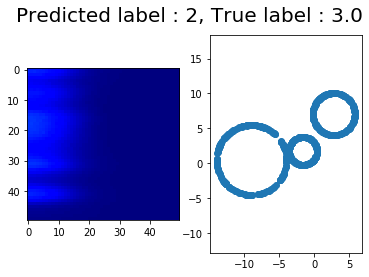

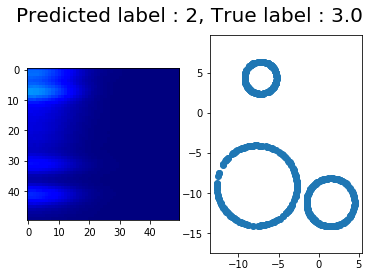

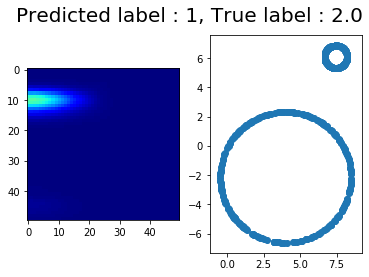

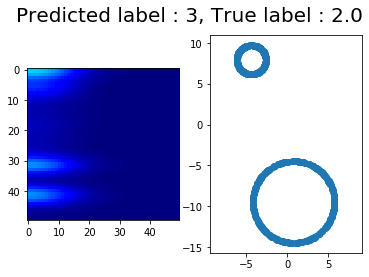

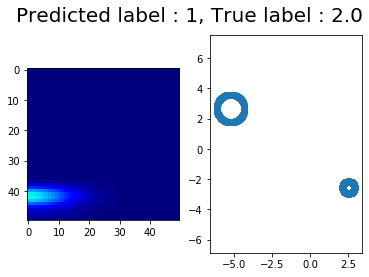

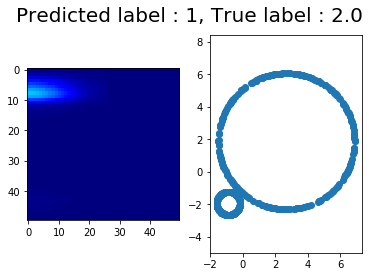

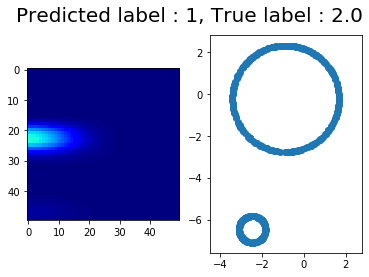

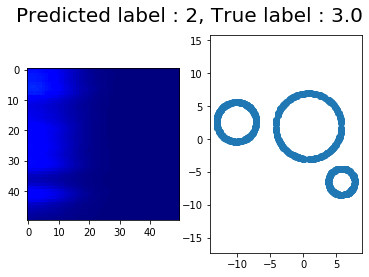

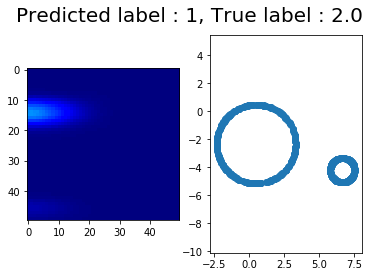

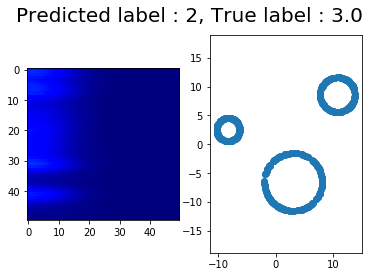

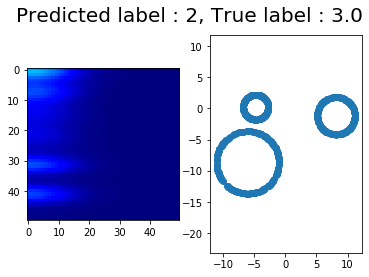

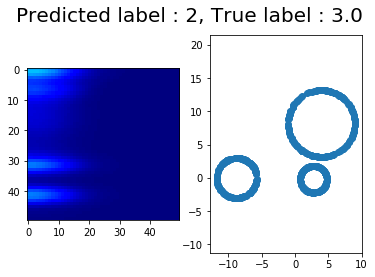

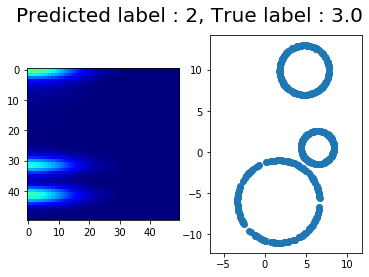

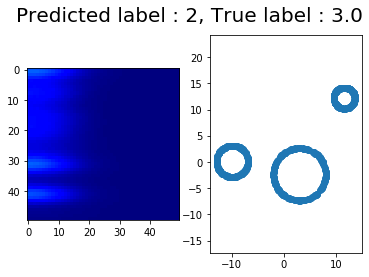

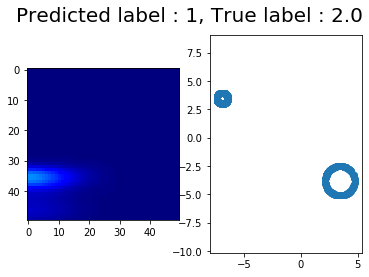

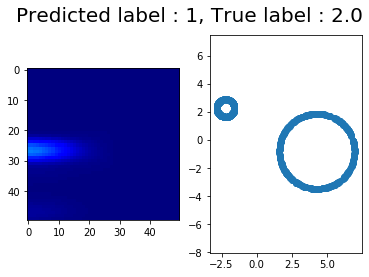

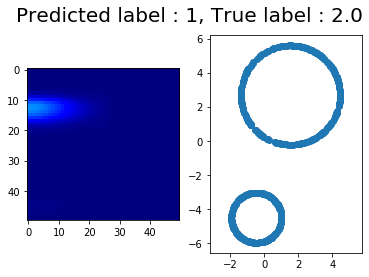

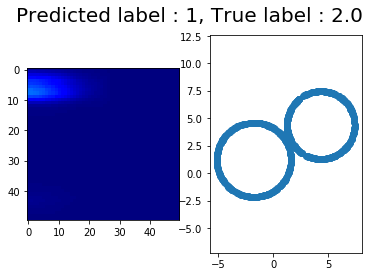

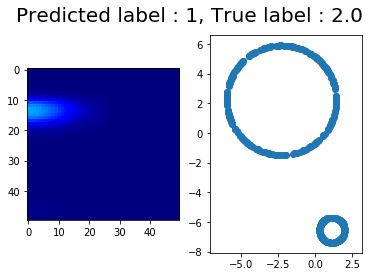

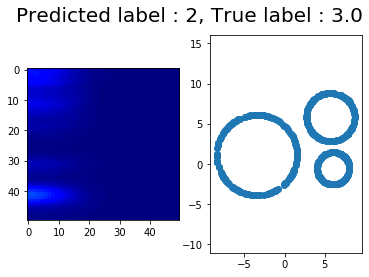

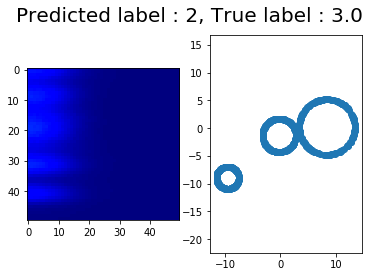

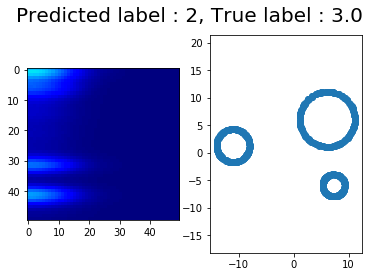

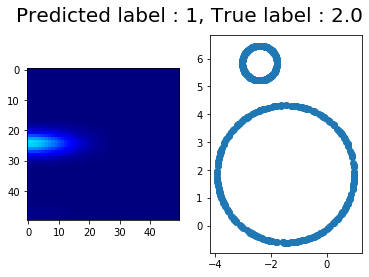

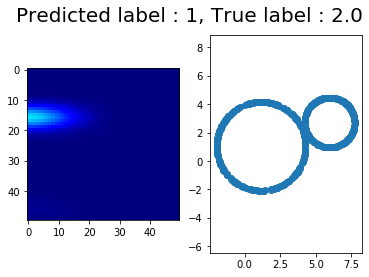

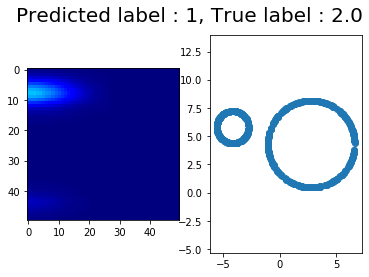

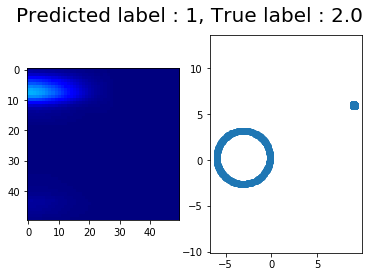

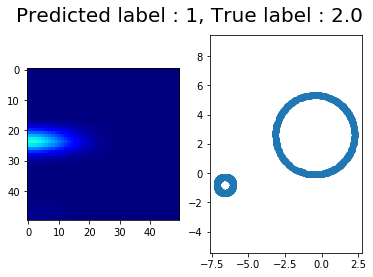

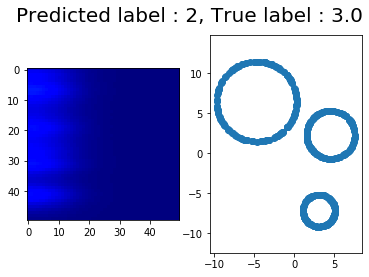

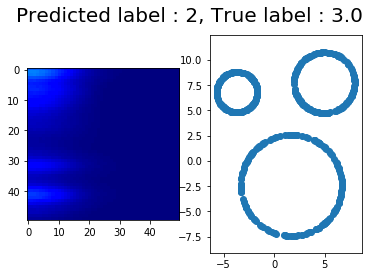

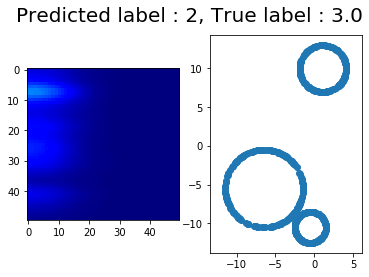

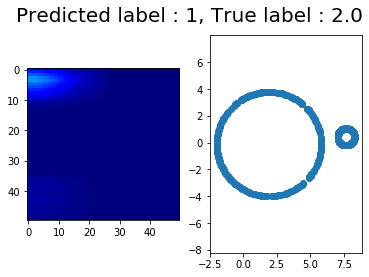

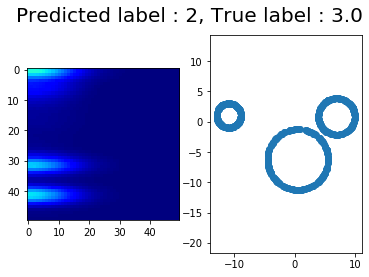

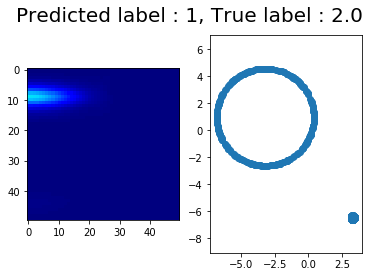

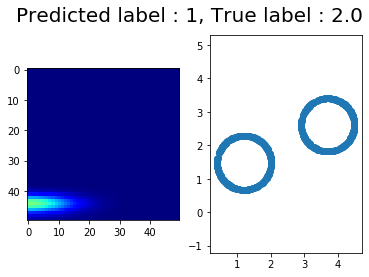

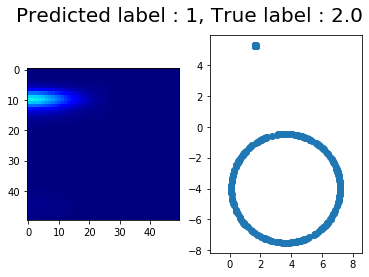

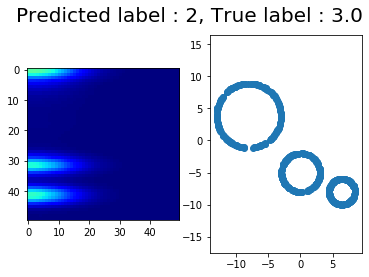

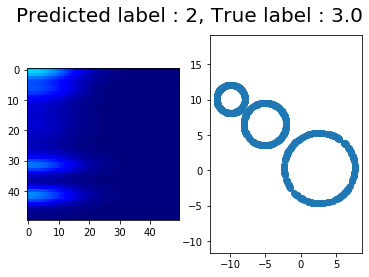

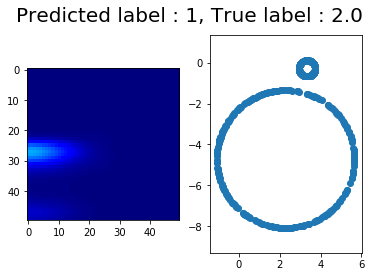

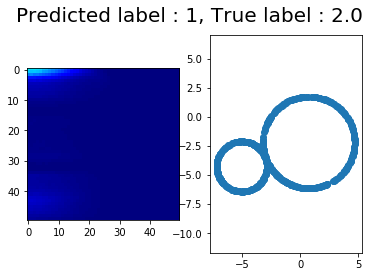

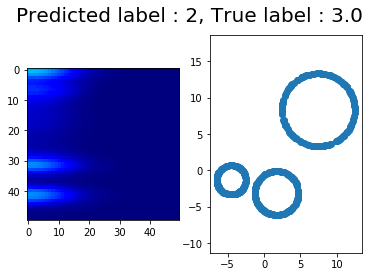

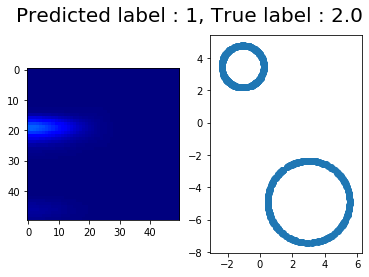

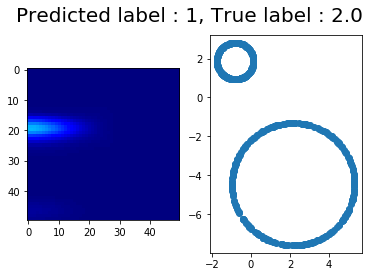

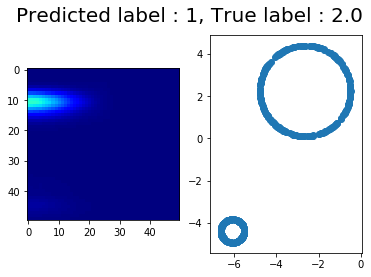

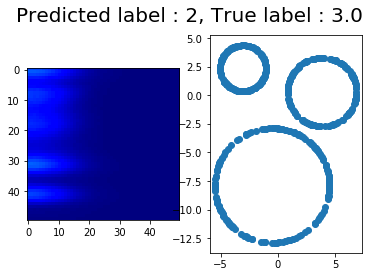

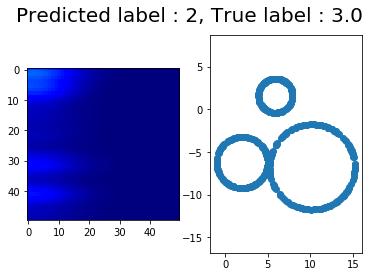

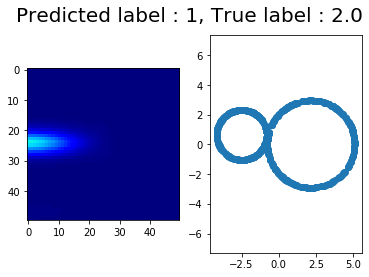

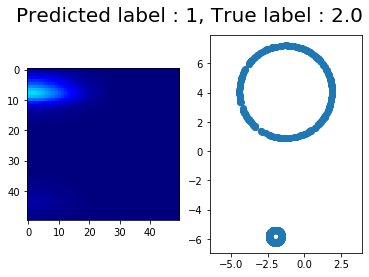

In [26]:
for i in range(len(pred)):
    if pred[i] != label_test_NN[i]:
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(np.flip(np.reshape(PI_test_NN[i], [PI_size, PI_size]), 0),
                   vmin=0,
                   vmax=1,
                   cmap='jet')
        
        plt.subplot(1,2,2)
        plt.scatter(data_test_NN[i,:,0],data_test_NN[i,:,1])
        plt.axis("equal")
        plt.suptitle("Predicted label : " + str(pred[i]+1) +", True label : "+ str(label_test_NN[i]+1),size=20)
        plt.savefig("Résultats/Résultats 4/Mislabeled/mislabeled"+str(i)+".pdf")


## Try with Random Forest

We try the classify the data based on their PIs but using a Random Forest instead of a NN.

In [27]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor(n_estimators = 100,verbose=1,n_jobs=-1)
rf.fit(PI_train_NN, label_train_NN)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min


In [41]:
res = rf.predict(PI_test_NN)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished


In [42]:
mis = 0
for i in range(len(PI_test_NN)):
    if int(res[i]) != label_test_NN[i]:
        mis += 1

In [43]:
mis

152

In [ ]:
rf.score(PI_test_NN,label_test_NN)